## 데이콘 비트코인 가격 예측 - Prophet pilot

### google drive mount

In [ ]:
# colab drive mount 
import os
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# 폴더 path 설정 및 working directory 변경
folder_path = './drive/MyDrive'
os.chdir(folder_path)


# current working directory 확인
print(os.getcwd())
''' 정상 경로 : /content/drive/My Drive '''


# data uploading folder create
dir_name = 'bitcoin_dataset'

def make_dir(dir_name):
    try:
        # Create target Directory
        os.mkdir(dir_name)
        print("Directory " , dir_name ,  " Created ") 
    except FileExistsError:
        print("Directory " , dir_name ,  " already exists")

# 폴더 생성
make_dir(dir_name)

# 폴더 생성됬는 지 확인 
print(os.listdir())

# 업로드할 디렉토리 변경
os.chdir('./bitcoin_dataset/')

# current working directroy confirm
print(os.getcwd())

/content/drive/MyDrive
Directory  bitcoin_dataset  already exists
['Colab Notebooks', '산갱', 'somethings', '.ipynb_checkpoints', '블로그 방문관련 이슈 조사.gform', '제목 없는 설문지.gform', 'bitcoin_dataset', '인증.png']
/content/drive/MyDrive/bitcoin_dataset


### library import and data upload

In [ ]:
# !pip install statsmodels==0.11.1
# !pip install fbprophet==0.7.1

In [ ]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.arima.model import ARIMA
import datetime
from fbprophet import Prophet

# 데이터 확인
print(os.listdir())

# read file
train_x_df = pd.read_csv("./train_x_df.csv")
train_y_df = pd.read_csv("./train_y_df.csv")
print("Reading Complete!")

['train_x_df.csv', 'train_y_df.csv', 'merged_data.h5', 'vanilla_GRU_model.h5', 'Bidirectional_GRU_model.h5']
Reading Complete!


### 함수 정의

In [ ]:
# numpy arrary conversion

def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

    # 샘플 확인

def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

### data reshaping

In [ ]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)

idx = 7657 #coin num = 9, sammple id = 7657 
data_col_idx = 1 # 1 open, 2 high

# open 가격만 가지고 arima 시행
x_series = train_x_array[idx,:,data_col_idx] 
y_series = train_y_array[idx,:,data_col_idx]

print(f'''

train_x_array {x_series.shape}
train_y_array {y_series.shape}

''')



train_x_array (1380,)
train_y_array (120,)




### data prepreocess for prophet

In [ ]:
start_time = '2021-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

# datafram 만들기
x_df = pd.DataFrame()
# 분당 시간 데이터 시리즈 입력
x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
# 가격 데이터 시리즈 입력
x_df['y'] = x_series.tolist()

x_df.head()

,ds,y
0,2021-01-31 00:01:00,1.005326
1,2021-01-31 00:02:00,1.005043
2,2021-01-31 00:03:00,1.004912
3,2021-01-31 00:04:00,1.002846
4,2021-01-31 00:05:00,1.002171


### modeling & prediciton

In [ ]:
prophet= Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality='auto',
                  weekly_seasonality='auto', daily_seasonality='auto',
                  changepoint_range=0.9,  
                  changepoint_prior_scale=0.1  # 오버피팅, 언더피팅을 피하기 위해 조정
                )

prophet.add_seasonality(name='first_seasonality', period=1/12, fourier_order=7) # seasonality 추가
prophet.add_seasonality(name='second_seasonality', period=1/8, fourier_order=15) # seasonality 추가

prophet.fit(x_df)

future_data = prophet.make_future_dataframe(periods=120, freq='min')
forecast_data = prophet.predict(future_data)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


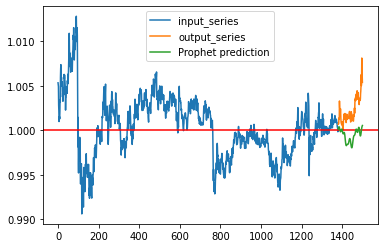

In [ ]:
pred_by_prophet = forecast_data.yhat.values[-120:]

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), pred_by_prophet, label = 'Prophet prediction')
plt.legend()
plt.show()

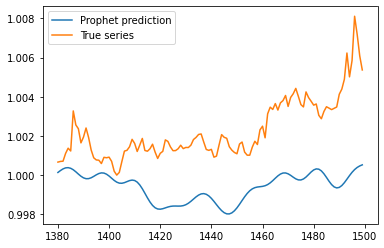

In [ ]:
plt.plot(np.arange(1380, 1380+120), pred_by_prophet, label = 'Prophet prediction')
plt.plot(np.arange(1380, 1380+120), y_series, label ='True series')
plt.legend()
plt.show()

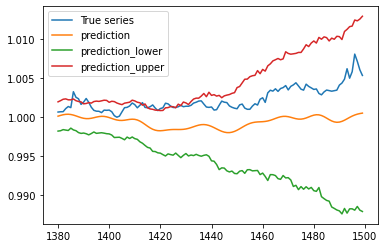

In [ ]:
pred_y = forecast_data.yhat.values[-120:]
pred_y_lower = forecast_data.yhat_lower.values[-120:]
pred_y_upper = forecast_data.yhat_upper.values[-120:]

plt.plot(np.arange(1380, 1380+120), y_series, label ='True series')
plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction')
plt.plot(np.arange(1380, 1380+120), pred_y_lower, label = 'prediction_lower')
plt.plot(np.arange(1380, 1380+120), pred_y_upper, label = 'prediction_upper')
plt.legend()
plt.show()